In [1]:
import torchaudio
root_path = '/kaggle/input/librispeech-clean'

In [3]:
train_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=False)

In [5]:
print(train_dataset[55])
import IPython.display as ipd
ipd.Audio(train_dataset[55][0].numpy(), rate=train_dataset[55][1])

(tensor([[-0.0019, -0.0020, -0.0009,  ...,  0.0068,  0.0083,  0.0031]]), 16000, "IT DOES REALLY SEEM AS IF I MUST BE DREAMING WELL I'M SORRY FOR THAT POOR YOUNG ONE AND NO MISTAKE MATTHEW AND MARILLA DON'T KNOW ANYTHING ABOUT CHILDREN AND THEY'LL EXPECT HIM TO BE WISER AND STEADIER THAT HIS OWN GRANDFATHER", 103, 1240, 55)


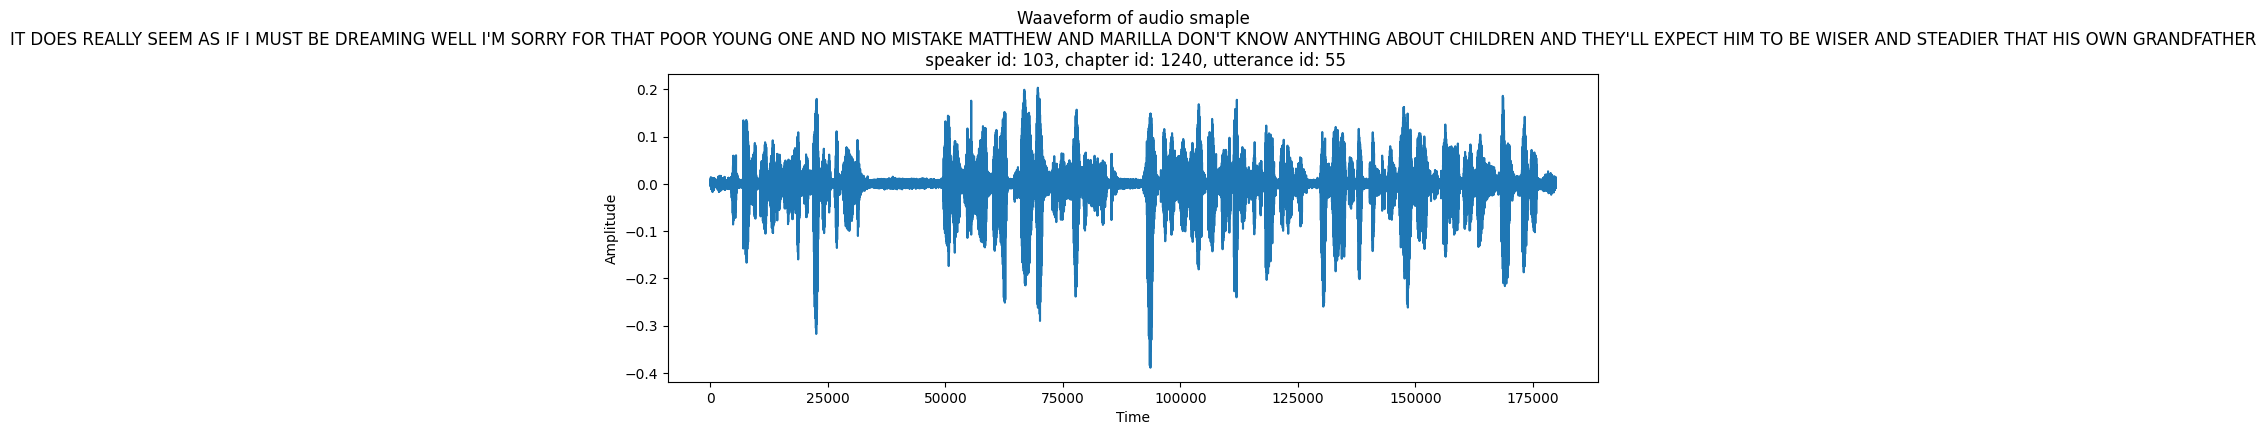

In [6]:
# Visulalize wavefrom
import matplotlib.pyplot as plt
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[55]
# plot the waveform
plt.figure(figsize =(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waaveform of audio smaple\n{utterance}\n speaker id: {speaker_id}, chapter id: {chapter_id}, utterance id: {utterance_id}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [7]:
import IPython.display as ipd
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [8]:
import string
from itertools import dropwhile

class TextTransform:
    """Maps characters to integers and vice verse, using the string module for cahracter definitions"""
    
    def __init__(self):
        # Including additional characters manually and using string.ascii_lowercase for latters
        additional_chars = ["''", '<SPACE>']
        all_chars = additional_chars + list(string.ascii_lowercase)
        
        # Generatring char_map with enumeration, starting indices from 0
        self.char_map = {char: i for i, char in enumerate(all_chars)}
        # Inverting char_map to crate index_map
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' ' 
        
    def text_to_int(self, text):
        '''Converts text to an interger sequences using a character map'''
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]
    
    def int_to_text(self, labels):
        '''converts integer labels to a text sequence using a character map'''
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')
    
    def int_to_text_remove_pad(self, int_sequence):
        # Remove trailing zeros which are used for padding
        # This is done by reversing the list, using itertools.dropwhile to drop the zeros,
        # and then reversing the list back to the original order
        from itertools import dropwhile

        # Reverse, remove zeros from the end (now start), and reverse back
        text_sequence = list(dropwhile(lambda x: x == 0, reversed(int_sequence)))[::-1]

        # Convert the non-padded sequence to text
        text = ''.join(self.index_map[i] for i in text_sequence).replace('<SPACE>', ' ')
        return text

    
# Example Usage 
text_transform = TextTransform()
test_text = 'This is Hakim'
test_ints = text_transform.text_to_int(test_text)
recovered_text = text_transform.int_to_text(test_ints)

print(f"original: {test_text}")
print(f"Converted to Int : {test_ints}")
print(f"Recoverd text: {recovered_text}")

original: This is Hakim
Converted to Int : [21, 9, 10, 20, 1, 10, 20, 1, 9, 2, 12, 10, 14]
Recoverd text: this is hakim


In [9]:
import torch
import torch.nn as nn

text_transform = TextTransform()

texts = ["Hello world", "My name is Hakim"]
labels = [torch.Tensor(text_transform.text_to_int(text)) for text in texts]
labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
labels

tensor([[ 9.,  6., 13., 13., 16.,  1., 24., 16., 19., 13.,  5.,  0.,  0.,  0.,
          0.,  0.],
        [14., 26.,  1., 15.,  2., 14.,  6.,  1., 10., 20.,  1.,  9.,  2., 12.,
         10., 14.]])

In [12]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[55]
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
spec.shape

torch.Size([900, 128])

In [17]:
spectrograms = []
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in [train_dataset[0], train_dataset[1]]:
    spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
    spectrograms.append(spec)
    
spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
spectrograms.size()


torch.Size([2, 1, 128, 1276])

In [18]:
import torch
import torch.nn as nn

def data_processing(data, data_type = 'train'):
    if data_type not in ['train', 'valid']:
        raise ValueError("data_type should be either 'trian' or 'valid.'")
        
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms
    
    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
        
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first = True).unsqueeze(1).transpose(2,3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first = True)
    return spectrograms, labels, input_lengths, label_lengths

In [20]:
import torch.utils.data as data

pipeline_params = {
    'batch_size': 10,
    'epochs': 1,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3, 
    'n_rnn_layers':5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats':  128,
    'stride': 2,
    'dropout': 0.1
}

kwargs = {'num_workers':1, 'pin_memory': True}
train_loader = data.DataLoader(dataset = train_dataset,
                              batch_size = pipeline_params['batch_size'],
                              shuffle = True,
                              collate_fn = lambda x: data_processing(x, 'train'),
                              **kwargs)
test_loader = data.DataLoader(dataset = test_dataset,
                             batch_size = pipeline_params['batch_size'],
                             shuffle = True,
                             collate_fn=lambda x: data_processing(x, 'valid'),
                             **kwargs)

In [24]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNN inputs."""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x: (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


In [25]:
class ResidualCNN(nn.Module):
    """Residual CNN with layer normalization and GELU activation."""
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel // 2)

        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)

        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)

        x += residual
        return x

class PositionalEncoding(nn.Module):
    """Positional encoding for the Transformer model"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x

In [28]:
class SpeechTransformer(nn.Module):
    """Transformer-based Speech Recognition Model"""
    def __init__(self, n_cnn_layers, n_transformer_layers, d_model, n_class, n_feats, dropout=0.1, n_heads=8, ff_dim=2048):
        super(SpeechTransformer, self).__init__()

        n_feats = n_feats // 2  # Reduce dimension after first CNN layer
        self.cnn = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  

        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])

        self.fc = nn.Linear(n_feats * 32, d_model)  # Flatten CNN output for Transformer

        self.pos_encoder = PositionalEncoding(d_model)


        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=ff_dim,
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_transformer_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_class)
        )


    def forward(self, x):
        # Convolutional feature extraction
        x = self.cnn(x)
        x = self.rescnn_layers(x)

        # Flatten CNN output for Transformer
        batch_size, channels, features, time = x.size()
        x = x.view(batch_size, channels * features, time)
        x = x.transpose(1, 2)  # (batch, time, features)

        x = self.fc(x)

        # Positional encoding and Transformer encoder
        x = self.pos_encoder(x)
        x = self.transformer(x)

        # Classifier
        x = self.classifier(x)
        return x

In [30]:
# --- Model Initialization ---
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SpeechTransformer(
    n_cnn_layers=pipeline_params['n_cnn_layers'],
    n_transformer_layers=6,  # You can modify the number of transformer layers
    d_model=pipeline_params['rnn_dim'],
    n_class=pipeline_params['n_class'],
    n_feats=pipeline_params['n_feats'],
    dropout=pipeline_params['dropout']
).to(device)

# Optimizer, Criterion, and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=pipeline_params["learning_rate"])
criterion = nn.CTCLoss(blank=28).to(device)


scheduler = OneCycleLR(
    optimizer,
    max_lr=pipeline_params["learning_rate"],
    steps_per_epoch=len(train_loader),
    epochs=pipeline_params["epochs"],
    anneal_strategy="linear"
)

# --- Training Loop ---
data_len = len(train_loader.dataset)
logging_idx = 0
logging_freq = 100


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

In [40]:
for epoch in range(pipeline_params["epochs"]):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{pipeline_params['epochs']}", unit="batches")
    
    for batch_idx, _data in progress_bar:
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()


        if logging_idx % logging_freq == 0:
            print(f"Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item()}")

        logging_idx += 1
        progress_bar.set_postfix({'loss': loss.item()})

Epoch 1/2:   0%|          | 1/2854 [00:00<19:44,  2.41batches/s, loss=7.38]

Epoch: 1, Batch: 0, Loss: 7.380303382873535


Epoch 1/2:   4%|▎         | 101/2854 [00:23<11:04,  4.14batches/s, loss=2.83]

Epoch: 1, Batch: 100, Loss: 2.8299148082733154


Epoch 1/2:   7%|▋         | 201/2854 [00:47<10:32,  4.19batches/s, loss=2.85]

Epoch: 1, Batch: 200, Loss: 2.8472306728363037


Epoch 1/2:  11%|█         | 301/2854 [01:11<09:49,  4.33batches/s, loss=2.88]

Epoch: 1, Batch: 300, Loss: 2.8821213245391846


Epoch 1/2:  14%|█▍        | 401/2854 [01:34<09:48,  4.17batches/s, loss=2.85]

Epoch: 1, Batch: 400, Loss: 2.8490214347839355


Epoch 1/2:  18%|█▊        | 501/2854 [01:57<09:08,  4.29batches/s, loss=2.88]

Epoch: 1, Batch: 500, Loss: 2.881300687789917


Epoch 1/2:  21%|██        | 601/2854 [02:21<09:00,  4.17batches/s, loss=2.91]

Epoch: 1, Batch: 600, Loss: 2.905977964401245


Epoch 1/2:  25%|██▍       | 701/2854 [02:44<08:19,  4.31batches/s, loss=2.83]

Epoch: 1, Batch: 700, Loss: 2.8285043239593506


Epoch 1/2:  28%|██▊       | 801/2854 [03:08<08:16,  4.13batches/s, loss=2.86]

Epoch: 1, Batch: 800, Loss: 2.855522871017456


Epoch 1/2:  32%|███▏      | 901/2854 [03:31<07:44,  4.21batches/s, loss=2.91]

Epoch: 1, Batch: 900, Loss: 2.9124820232391357


Epoch 1/2:  35%|███▌      | 1001/2854 [03:55<07:23,  4.18batches/s, loss=2.82]

Epoch: 1, Batch: 1000, Loss: 2.818183183670044


Epoch 1/2:  39%|███▊      | 1101/2854 [04:18<06:59,  4.18batches/s, loss=2.7] 

Epoch: 1, Batch: 1100, Loss: 2.6980443000793457


Epoch 1/2:  42%|████▏     | 1201/2854 [04:42<06:29,  4.25batches/s, loss=2.48]

Epoch: 1, Batch: 1200, Loss: 2.479929208755493


Epoch 1/2:  46%|████▌     | 1301/2854 [05:05<06:09,  4.20batches/s, loss=2.21]

Epoch: 1, Batch: 1300, Loss: 2.2149927616119385


Epoch 1/2:  49%|████▉     | 1401/2854 [05:29<05:46,  4.19batches/s, loss=2.37]

Epoch: 1, Batch: 1400, Loss: 2.3711395263671875


Epoch 1/2:  53%|█████▎    | 1501/2854 [05:52<05:12,  4.33batches/s, loss=2.13]

Epoch: 1, Batch: 1500, Loss: 2.1268765926361084


Epoch 1/2:  56%|█████▌    | 1601/2854 [06:16<04:55,  4.25batches/s, loss=2.16]

Epoch: 1, Batch: 1600, Loss: 2.158205509185791


Epoch 1/2:  60%|█████▉    | 1701/2854 [06:39<04:34,  4.20batches/s, loss=2]   

Epoch: 1, Batch: 1700, Loss: 1.9993164539337158


Epoch 1/2:  63%|██████▎   | 1801/2854 [07:03<04:07,  4.25batches/s, loss=1.98]

Epoch: 1, Batch: 1800, Loss: 1.9823211431503296


Epoch 1/2:  67%|██████▋   | 1901/2854 [07:26<03:43,  4.26batches/s, loss=1.95]

Epoch: 1, Batch: 1900, Loss: 1.9505691528320312


Epoch 1/2:  70%|███████   | 2001/2854 [07:49<03:26,  4.12batches/s, loss=1.93]

Epoch: 1, Batch: 2000, Loss: 1.931273341178894


Epoch 1/2:  74%|███████▎  | 2101/2854 [08:13<02:49,  4.45batches/s, loss=1.85]

Epoch: 1, Batch: 2100, Loss: 1.8483349084854126


Epoch 1/2:  77%|███████▋  | 2201/2854 [08:36<02:36,  4.18batches/s, loss=1.78]

Epoch: 1, Batch: 2200, Loss: 1.7792587280273438


Epoch 1/2:  81%|████████  | 2301/2854 [09:00<02:12,  4.18batches/s, loss=1.83]

Epoch: 1, Batch: 2300, Loss: 1.8346697092056274


Epoch 1/2:  84%|████████▍ | 2401/2854 [09:23<01:47,  4.22batches/s, loss=2]   

Epoch: 1, Batch: 2400, Loss: 2.002763032913208


Epoch 1/2:  88%|████████▊ | 2501/2854 [09:47<01:21,  4.32batches/s, loss=1.83]

Epoch: 1, Batch: 2500, Loss: 1.8270171880722046


Epoch 1/2:  91%|█████████ | 2601/2854 [10:10<00:58,  4.36batches/s, loss=1.89]

Epoch: 1, Batch: 2600, Loss: 1.8895291090011597


Epoch 1/2:  95%|█████████▍| 2701/2854 [10:34<00:36,  4.21batches/s, loss=1.7] 

Epoch: 1, Batch: 2700, Loss: 1.695815920829773


Epoch 1/2:  98%|█████████▊| 2801/2854 [10:57<00:12,  4.33batches/s, loss=1.67]

Epoch: 1, Batch: 2800, Loss: 1.6666465997695923


Epoch 2/2:   2%|▏         | 47/2854 [00:11<11:03,  4.23batches/s, loss=1.7] 

Epoch: 2, Batch: 46, Loss: 1.7026211023330688


Epoch 2/2:   5%|▌         | 147/2854 [00:34<10:43,  4.20batches/s, loss=1.84]

Epoch: 2, Batch: 146, Loss: 1.8381842374801636


Epoch 2/2:   9%|▊         | 247/2854 [00:57<10:18,  4.22batches/s, loss=1.78]

Epoch: 2, Batch: 246, Loss: 1.7820634841918945


Epoch 2/2:  12%|█▏        | 347/2854 [01:21<09:42,  4.30batches/s, loss=1.73]

Epoch: 2, Batch: 346, Loss: 1.7307922840118408


Epoch 2/2:  16%|█▌        | 447/2854 [01:44<09:10,  4.37batches/s, loss=1.57]

Epoch: 2, Batch: 446, Loss: 1.568026065826416


Epoch 2/2:  19%|█▉        | 547/2854 [02:08<09:15,  4.16batches/s, loss=1.66]

Epoch: 2, Batch: 546, Loss: 1.6603797674179077


Epoch 2/2:  23%|██▎       | 647/2854 [02:31<08:28,  4.34batches/s, loss=1.73]

Epoch: 2, Batch: 646, Loss: 1.731044054031372


Epoch 2/2:  26%|██▌       | 747/2854 [02:55<08:12,  4.27batches/s, loss=1.58]

Epoch: 2, Batch: 746, Loss: 1.5828219652175903


Epoch 2/2:  30%|██▉       | 847/2854 [03:18<07:58,  4.19batches/s, loss=1.79]

Epoch: 2, Batch: 846, Loss: 1.7897495031356812


Epoch 2/2:  33%|███▎      | 947/2854 [03:42<07:17,  4.36batches/s, loss=1.57]

Epoch: 2, Batch: 946, Loss: 1.5662798881530762


Epoch 2/2:  37%|███▋      | 1047/2854 [04:05<07:06,  4.23batches/s, loss=1.61]

Epoch: 2, Batch: 1046, Loss: 1.6085220575332642


Epoch 2/2:  40%|████      | 1147/2854 [04:29<06:33,  4.34batches/s, loss=1.47]

Epoch: 2, Batch: 1146, Loss: 1.4654219150543213


Epoch 2/2:  44%|████▎     | 1247/2854 [04:52<06:12,  4.32batches/s, loss=1.52]

Epoch: 2, Batch: 1246, Loss: 1.5173677206039429


Epoch 2/2:  47%|████▋     | 1347/2854 [05:16<05:39,  4.44batches/s, loss=1.45]

Epoch: 2, Batch: 1346, Loss: 1.4520188570022583


Epoch 2/2:  51%|█████     | 1447/2854 [05:39<05:30,  4.25batches/s, loss=1.62]

Epoch: 2, Batch: 1446, Loss: 1.620895266532898


Epoch 2/2:  54%|█████▍    | 1547/2854 [06:03<05:12,  4.18batches/s, loss=1.79]

Epoch: 2, Batch: 1546, Loss: 1.7929280996322632


Epoch 2/2:  58%|█████▊    | 1647/2854 [06:26<04:42,  4.27batches/s, loss=1.43]

Epoch: 2, Batch: 1646, Loss: 1.4324077367782593


Epoch 2/2:  61%|██████    | 1747/2854 [06:50<04:13,  4.36batches/s, loss=1.57]

Epoch: 2, Batch: 1746, Loss: 1.5740711688995361


Epoch 2/2:  65%|██████▍   | 1847/2854 [07:13<03:55,  4.27batches/s, loss=1.5] 

Epoch: 2, Batch: 1846, Loss: 1.496259093284607


Epoch 2/2:  68%|██████▊   | 1947/2854 [07:37<03:38,  4.16batches/s, loss=1.64]

Epoch: 2, Batch: 1946, Loss: 1.644150733947754


Epoch 2/2:  72%|███████▏  | 2047/2854 [08:00<03:09,  4.25batches/s, loss=1.58]

Epoch: 2, Batch: 2046, Loss: 1.5828129053115845


Epoch 2/2:  75%|███████▌  | 2147/2854 [08:24<02:46,  4.25batches/s, loss=1.49]

Epoch: 2, Batch: 2146, Loss: 1.4877556562423706


Epoch 2/2:  79%|███████▊  | 2247/2854 [08:47<02:31,  4.01batches/s, loss=1.47]

Epoch: 2, Batch: 2246, Loss: 1.4736591577529907


Epoch 2/2:  82%|████████▏ | 2347/2854 [09:11<02:00,  4.22batches/s, loss=1.44]

Epoch: 2, Batch: 2346, Loss: 1.4388771057128906


Epoch 2/2:  86%|████████▌ | 2447/2854 [09:34<01:37,  4.17batches/s, loss=1.67]

Epoch: 2, Batch: 2446, Loss: 1.6653870344161987


Epoch 2/2:  89%|████████▉ | 2547/2854 [09:58<01:13,  4.20batches/s, loss=1.58]

Epoch: 2, Batch: 2546, Loss: 1.5751761198043823


Epoch 2/2:  93%|█████████▎| 2647/2854 [10:21<00:48,  4.25batches/s, loss=1.48]

Epoch: 2, Batch: 2646, Loss: 1.480206847190857


Epoch 2/2:  96%|█████████▋| 2747/2854 [10:45<00:24,  4.37batches/s, loss=1.42]

Epoch: 2, Batch: 2746, Loss: 1.4151458740234375


Epoch 2/2: 100%|█████████▉| 2847/2854 [11:08<00:01,  4.40batches/s, loss=1.45]

Epoch: 2, Batch: 2846, Loss: 1.4509773254394531


Epoch 2/2: 100%|██████████| 2854/2854 [11:10<00:00,  4.26batches/s, loss=1.33]


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    """Positional Encoding for Transformers"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransformerEncoder(nn.Module):
    """Transformer Encoder Block with Padding Mask Support"""
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super(TransformerEncoder, self).__init__()
        self.layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, x, mask=None):
        return self.layer(x, src_key_padding_mask=mask)


class SpeechRecognitionTransformer(nn.Module):
    """Transformer Speech Recognition Model with RNN-Matching Output Dimensions"""
    
    def __init__(self, n_cnn_layers, n_transformer_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1, nhead=8, dim_feedforward=2048):
        super(SpeechRecognitionTransformer, self).__init__()

        # CNN Feature Extractor
        n_feats = n_feats // 2  # Match the feature dimension reduction in the RNN model
        self.cnn = nn.Conv2d(1, 32, kernel_size=3, stride=stride, padding=1)

        # Residual CNN Layers
        self.rescnn_layers = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(n_cnn_layers)
        ])
        
        # Linear projection to match RNN model's fully connected layer output
        self.fc = nn.Linear(n_feats * 32, rnn_dim)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(rnn_dim)

        # Transformer Encoder Layers
        self.transformer = nn.ModuleList([
            TransformerEncoder(rnn_dim, nhead, dim_feedforward, dropout)
            for _ in range(n_transformer_layers)
        ])

        # Final classifier matching the RNN model output dimensions
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim, rnn_dim * 2),  # Match Bi-GRU output shape
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim * 2, n_class)  # Final output dimension: (batch, time, n_class)
        )

    def forward(self, x, mask=None):
        # CNN Feature Extraction
        x = self.cnn(x)
        x = self.rescnn_layers(x)

        # Reshape for Transformer
        batch, channel, feature, time = x.shape
        x = x.view(batch, channel * feature, time).transpose(1, 2)  # (batch, time, features)

        # Fully connected projection
        x = self.fc(x)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Transformer Layers with Padding Mask Support
        for layer in self.transformer:
            x = layer(x, mask)

        # Final classifier
        x = self.classifier(x)

        return x


# Define pipeline parameters (matching the original RNN model)
pipeline_params = {
    'batch_size': 10,
    'epochs': 2,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3, 
    'n_transformer_layers': 6,  # Replace RNN layers with Transformer layers
    'rnn_dim': 512,  # Same as original RNN model's hidden size
    'n_class': 29,
    'n_feats': 128,
    'stride': 2,
    'dropout': 0.1,
    'nhead': 8,
    'dim_feedforward': 2048
}

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeechRecognitionTransformer(
    n_cnn_layers=pipeline_params['n_cnn_layers'],
    n_transformer_layers=pipeline_params['n_transformer_layers'],
    rnn_dim=pipeline_params['rnn_dim'],
    n_class=pipeline_params['n_class'],
    n_feats=pipeline_params['n_feats'],
    stride=pipeline_params['stride'],
    dropout=pipeline_params['dropout'],
    nhead=pipeline_params['nhead'],
    dim_feedforward=pipeline_params['dim_feedforward']
).to(device)

# Optimizer, Criterion, and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=pipeline_params["learning_rate"])
criterion = nn.CTCLoss(blank=28).to(device)


scheduler = OneCycleLR(
    optimizer,
    max_lr=pipeline_params["learning_rate"],
    steps_per_epoch=len(train_loader),
    epochs=pipeline_params["epochs"],
    anneal_strategy="linear"
)

# --- Training Loop ---
data_len = len(train_loader.dataset)
logging_idx = 0
logging_freq = 100


In [80]:
class CTCCharTokenizer:
    def __init__(self, blank=28):
        self.blank = blank
        self.index_to_char = [
            '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
            'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '
        ]
        self.char_to_index = {char: idx for idx, char in enumerate(self.index_to_char)}

    def decode(self, tokens):
        """ Convert token indices to text """
        text = []
        for token in tokens:
            if token != self.blank:
                text.append(self.index_to_char[token])
        return ''.join(text)
    
    def encode(self, text):
        """ Convert text to token indices """
        return [self.char_to_index[char] for char in text if char in self.char_to_index]

# Instantiate the tokenizer
tokenizer = CTCCharTokenizer()


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def eda_on_test_loader(test_loader, tokenizer, device):
    """
    Perform EDA on the test_loader:
    - Min, max, and average duration
    - Top 50 frequent words
    """
    durations = []
    all_words = []
    total_samples = 0
    total_label_length = 0

    print("\n--- Running EDA on Test Loader ---\n")

    for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_loader):
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        # --- Duration Calculation ---
        batch_duration = (input_lengths * pipeline_params['stride']).tolist()
        durations.extend(batch_duration)

        # --- Extract words ---
        for label in labels:
            label = label.cpu().numpy()
            text = tokenizer.decode(label)  # Convert label to text
            all_words.extend(text.split())

            total_samples += 1
            total_label_length += len(label)

        if batch_idx % 10 == 0:
            print(f"Processed {batch_idx * len(spectrograms)} samples...")

    # --- Duration Stats ---
    min_duration = min(durations)
    max_duration = max(durations)
    avg_duration = np.mean(durations)

    print("\n--- Duration Stats ---")
    print(f"Minimum Duration: {min_duration:.2f} seconds")
    print(f"Maximum Duration: {max_duration:.2f} seconds")
    print(f"Average Duration: {avg_duration:.2f} seconds")
    
    # --- Word Frequency ---
    word_counter = Counter(all_words)
    top_50_words = word_counter.most_common(50)

    print("\n--- Top 50 Frequent Words ---")
    for word, freq in top_50_words:
        print(f"{word}: {freq}")

    # --- Visualization ---
    plt.figure(figsize=(12, 6))

    # Histogram of Durations
    plt.subplot(1, 2, 1)
    plt.hist(durations, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Audio Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")

    # Top 50 Words
    plt.subplot(1, 2, 2)
    words, freqs = zip(*top_50_words)
    plt.barh(words[::-1], freqs[::-1], color='lightgreen')
    plt.title("Top 50 Frequent Words")
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    plt.tight_layout()
    plt.show()

    print("\n--- Dataset Statistics ---")
    print(f"Total Samples: {total_samples}")
    print(f"Average Label Length: {total_label_length / total_samples:.2f} tokens")

# --- Running the EDA ---
eda_on_test_loader(test_loader, tokenizer, device)


In [86]:
# Function to display sample information from the test_loader
def inspect_test_loader(test_loader, tokenizer, device, num_batches=3):
    """
    Inspect the details of the test loader
    Args:
        - test_loader: DataLoader object containing test data
        - tokenizer: Tokenizer used for decoding labels
        - device: Device to load tensors
        - num_batches: Number of batches to inspect
    """
    print("="*40)
    print(f"🧐 Inspecting {num_batches} batches from test_loader...\n")
    print("="*40)
    
    for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_loader):
        print(f"Batch {batch_idx + 1}/{num_batches}")
        print("-" * 40)
        
        # Move tensors to device
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        
        # Check dimensions
        print(f"Spectrogram shape: {spectrograms.shape} (Batch, Channels, Features, Time)")
        print(f"Labels shape: {labels.shape} (Batch, Label Length)")
        
        # Check lengths
        print(f"Input lengths: {input_lengths}")
        print(f"Label lengths: {label_lengths}")
        
        # Display some label samples
        print("\n📚 Sample Transcriptions:")
        for i in range(min(5, len(labels))):  # Print first 5 samples in the batch
            label = labels[i][:label_lengths[i]].cpu().numpy()
            label = label.astype(int) 
            
            # Decode using the tokenizer
            if hasattr(tokenizer, "decode"):
                decoded_text = tokenizer.decode(label)
            else:
                decoded_text = ''.join([tokenizer.index_to_char[idx] for idx in label])

            print(f"  - Sample {i + 1}: {decoded_text}")
        
        print("=" * 40)

        if batch_idx + 1 >= num_batches:
            break


In [87]:
inspect_test_loader(test_loader, tokenizer, device)

🧐 Inspecting 3 batches from test_loader...

Batch 1/3
----------------------------------------
Spectrogram shape: torch.Size([10, 1, 128, 1828]) (Batch, Channels, Features, Time)
Labels shape: torch.Size([10, 349]) (Batch, Label Length)
Input lengths: [99, 914, 103, 170, 381, 474, 509, 580, 133, 118]
Label lengths: [29, 349, 41, 34, 142, 149, 211, 227, 46, 29]

📚 Sample Transcriptions:
  - Sample 1: uibuajtadpnqbsbujwfmzaopuijoh
  - Sample 2: barvbsufsapgaboaipvsabgufsxbsetaifasfuvsofeaupauifauifbufsacvuajuaxjmmacfasfbejmzacfmjfwfeauibuajuaxbtapomzabaqpxfsgvmafggpsuapgasfbtpoapwfsaijtahsfbuafydjufnfouauibuafobcmfeaijnaupahpacbdlapsaqfsibqtagpsampwfajtauivtatusbohfmzadpotujuvufeaifagpvoeajuajnqpttjcmfafwfoaupasfnbjoanvdiampohfsatfqbsbufeagspnauifaqsftfodfapgapofaxipaibeacsplfoaijtaifbsu
  - Sample 3: opxamfuataevtuauifagvsojuvsfaboeaqjduvsft
  - Sample 4: jalopxaopatvdiaqmbdfatbjeauifausff
  - Sample 5: jabnaopuabmmpxfeaupaqfsgpsnanbhjdafydfquagpsanzapxoabnvtfnfouaifaupmeaijtawjtjupstab

In [90]:
count =0 
for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_loader):
    count = count + 1

print(count)

262


In [94]:
len(test_loader)
test_dataset[2]

(tensor([[ 0.0004,  0.0006,  0.0008,  ..., -0.0001, -0.0004, -0.0007]]),
 16000,
 'AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS',
 1089,
 134686,
 2)

In [96]:
for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_loader):
    for i in range(labels.size(0)):  # Loop through each sample in the batch
        label_tensor = labels[i][:label_lengths[i]]  # Extract the valid portion of the label
        label_ints = label_tensor.tolist()  # Convert to list of integers
        label_text = text_transform.int_to_text(label_ints)  # Convert integers back to text
        print(f"Sample {i + 1}: {label_text}")
        print(spectrograms)
        break
    break

Sample 1: they couldn t run nor move they re just pasteboard
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4383e-04, 1.1992e-06, 1.5174e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7440e-04, 6.4569e-06, 8.1700e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.9430e-07, 6.0592e-07, 1.0862e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.9974e-07, 8.1600e-07, 6.4362e-07,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5837e-07, 2.6444e-07, 8.9585e-07,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5528e-04, 7.7455e-04, 1.3638e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0666e-03, 4.1704e-03, 7.3433e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          .

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

def spectrogram_to_audio(spectrogram, n_fft=400, win_length=400, hop_length=160, power=2.0, num_iters=32, sample_rate=16000):
    """
    Converts a spectrogram back to audio using Griffin-Lim algorithm.
    
    Args:
        spectrogram (torch.Tensor): Spectrogram of shape [1, 1, freq, time].
        n_fft (int): Number of FFT bins.
        win_length (int): Window length.
        hop_length (int): Hop length.
        power (float): Exponent for the magnitude spectrogram.
        num_iters (int): Number of Griffin-Lim iterations.
        sample_rate (int): Sample rate of the output audio.
    
    Returns:
        waveform (torch.Tensor): The reconstructed audio waveform.
    """
    # Remove batch and channel dimensions
    if spectrogram.ndim == 4:
        spectrogram = spectrogram.squeeze(0).squeeze(0)  # [freq, time]

    # Convert magnitude spectrogram to complex tensor
    inverse_transform = T.GriffinLim(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power, n_iter=num_iters)
    
    # Perform Griffin-Lim
    waveform = inverse_transform(spectrogram)

    return waveform

# Example usage
# Assuming `spectrograms` is the batch output from your DataLoader
sample_spectrogram = spectrograms[0]  # Get the first sample
waveform = spectrogram_to_audio(sample_spectrogram)

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title("Reconstructed Audio Waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

# Save as audio file (optional)
torchaudio.save("reconstructed_audio.wav", waveform.unsqueeze(0), 16000)
